In [14]:
%pip install pandas
%pip install scipy
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc
import matplotlib.cm as cm
from read_arrays_from_csv import bhl_object_list, bhl_object_labels
from plot_variables import *

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [15]:
def setup_plot_env(fontsize, linewidth):
    rc('font', **{'family': 'serif', 'serif': ['Times'], 'weight': 'light'})
    rc('text', usetex=True)
    plt.rcParams["mathtext.default"] = "regular"
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['lines.linewidth'] = linewidth


# Function to format and create the subplots
def create_subplots(num_subplots, xlim, ylim_mass, time_cutoff, fontsize, title):
    fig, axs = plt.subplots(num_subplots, 1, sharex=True)

    for i in range(num_subplots):
        axs[i].set_xticks(np.arange(0.1, time_cutoff+0.1, 0.1))
        axs[i].minorticks_on()
        axs[i].xaxis.set_minor_locator(plt.MultipleLocator(0.02))
        axs[i].tick_params(axis="x", which='minor', length=2, direction="in")
        axs[i].tick_params(axis="x", which='major', labelsize=fontsize-1, width=1.5, length=3, direction="in")
        axs[i].tick_params(axis="y", which='major', labelsize=fontsize-1)
        axs[i].tick_params(axis="y", which='minor', labelsize=fontsize-2)
        axs[i].set_yscale('log')
        axs[i].set_xlim([0, xlim+0.01]) # for truncated view

    axs[0].set_title(title)
    axs[0].set_ylim([10.5, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
    axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
    axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
    axs[1].set_ylim([2e-9, 8e-4]) # [2e-9, 8e-4] for 270msun, [5e-9, 6e-2] for 10.8msun-no-SN, [2e-9, 8e-4] for 10.8msun
    axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

    return fig, axs

def plot_extra_line_mass_growth(j, data_file, label_extra, alpha=0.8):
        # Load the CSV file into a DataFrame
        df = pd.read_csv(data_file)

        # Extract the columns you're interested in
        age = df['age'].values/1e6
        bh_mass = df['BH mass'].values
        accrate = df['accrate'].values

        # 1) BH Mass
        axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=label_extra, alpha=alpha)

        # 2) Accretion Rates
        axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=label_extra, alpha=alpha)
        axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=label_extra, alpha=alpha)

        return 0

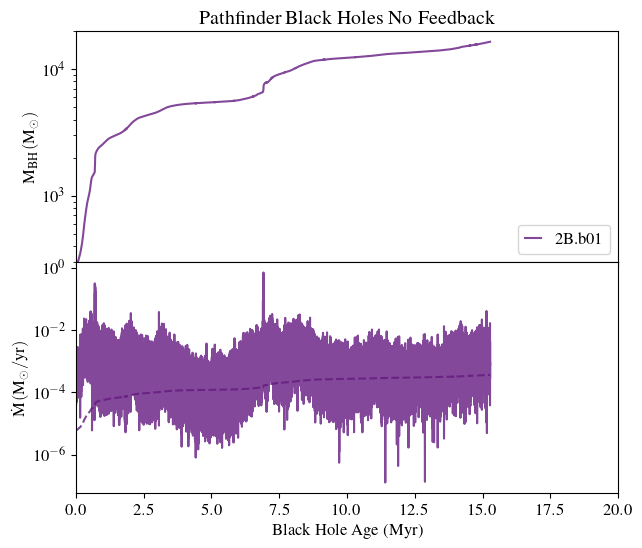

In [50]:
from plot_variables import moving_average

# Set axes limits 
time_cutoff = 20
ylim_mass = 2e4

# Set up plot environment
fontsize = 12
linewidth = 1.5
alpha = 0.8
setup_plot_env(fontsize, linewidth)
num_subplots = 2
title = 'Pathfinder Black Holes No Feedback'
fig, axs = plt.subplots(num_subplots, 1, sharex=True)

# Set limits and labels
axs[0].set_ylim([300, ylim_mass+0.01]) # for truncated view 270msun: [240, ylim_mass+0.01]
for i in range(num_subplots):
    axs[i].set_yscale('log')
    axs[i].set_xlim([0, time_cutoff]) # for truncated view
axs[0].set_ylabel(r"$\rm M_{BH} \, (M_{\odot})$", fontdict=None)
axs[1].set_ylabel(r"$\rm \dot{M} \, (M_{\odot}/yr)$", fontdict=None)
axs[-1].set_xlabel('Black Hole Age (Myr)', fontdict=None)

# Line colours
c_s1 = extract_colors('viridis', num_subplots-1, portion="middle", start=0.35, end=0.92) # start=0.33, end=0.92 for 10.8msun-no-sn
c_s2 = extract_colors('magma', num_subplots-1, portion="middle", start=0.3, end=0.85) # start=0.3, end=0.85 for 10.8msun-no-sn
c = np.concatenate((c_s1, c_s2))

# Load the CSV file into a DataFrame
data_files = [#'data_files/data-1B.RSb01-2.csv', 
              'data_files/data-2B.RSb01.csv']
labels = ['1B.b01', '2B.b01']
for j, data_file in enumerate(data_files):
    j +=1
    df = pd.read_csv(data_file)

    # Extract the columns you're interested in
    window_size = 1
    age = df['age'].values/1e6
    bh_mass = moving_average(df['BH mass'].values, window_size)
    accrate = moving_average(df['accrate'].values, window_size)
    #age = np.linspace(age[0], times[-1], len(accrate))

    # 1) BH Mass
    axs[0].plot(age, bh_mass, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)

    # 2) Accretion Rates
    axs[1].plot(age, accrate, color=c[j], linestyle='solid', label=labels[j], alpha=alpha)
    axs[1].plot(age, eddington_rate(bh_mass), color=c[j], linestyle='dashed', label=labels[j], alpha=alpha)


axs[0].legend(fontsize=fontsize, ncol=2, loc="lower right", handlelength=1) # "lower right" for no-sn
#axs[1].legend(accrate_line, [r"$\rm \dot{M}_{Edd}$"], loc="lower right", fontsize=fontsize-2.2, ncol=1)
fig.subplots_adjust(wspace=0, hspace=0)
axs[0].set_title(title)
fig.set_size_inches(7, 6)
plt.savefig(f'no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf', bbox_inches='tight')
plt.show()

In [ ]:
plt.savefig(f'no-feedback-pathfinders/mass_accrate_{labels[0]}_{labels[1]}_{time_cutoff}.pdf', bbox_inches='tight')